In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_celeba_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/CelebA_Ppc/0516_153043/checkpoint_4499.ckpt")

Missing logger folder: saved/log/CelebA_Ppc/0516_195540/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0516_195540 exists and is not empty.
Restoring states from the checkpoint path at saved/models/CelebA_Ppc/0516_153043/checkpoint_4499.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0516_153043' to '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0516_195540', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type       | Params
------------------------------------------
0 | graph      | CelebAPpc  | 389 K 
1 | predictive | Predictive | 0     
--------------------------------

Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
`Trainer.fit` stopped: `max_epochs=4500` reached.


In [7]:
model.graph.clear()
model.eval()
model.cuda()

LightningPpc(
  (graph): CelebAPpc(
    (prior): GaussianPrior()
    (likelihood): ConvolutionalDecoder(
      (linear): Sequential(
        (0): Linear(in_features=40, out_features=256, bias=True)
        (1): SiLU()
      )
      (convs): Sequential(
        (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
        (1): SiLU()
        (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (9): Identity()
        (10): Identity()
      )
    )
  )
  (predictive): Predictive()
)

In [8]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)
model._load_particles(indices, False)

In [9]:
for i in range(299):
    _, log_weight = model.graph(lr=1e-3, P=model.num_particles, xs=xs)
    logger.info("Free energy at evaluation %d: %f" % (i+1, -log_weight.mean()))
trace, _ = model.graph(lr=1e-3, P=model.num_particles, xs=xs)
logger.info("Free energy at evaluation 300: %f" % -log_weight.mean())
x_hats = trace.nodes['X']['fn'].base_dist.loc.mean(dim=0)

Free energy at evaluation 1: 11541.875000
Free energy at evaluation 2: 11539.132812
Free energy at evaluation 3: 11537.477539
Free energy at evaluation 4: 11535.876953
Free energy at evaluation 5: 11534.607422
Free energy at evaluation 6: 11533.335938
Free energy at evaluation 7: 11532.244141
Free energy at evaluation 8: 11531.157227
Free energy at evaluation 9: 11530.093750
Free energy at evaluation 10: 11529.166016
Free energy at evaluation 11: 11528.237305
Free energy at evaluation 12: 11527.390625
Free energy at evaluation 13: 11526.580078
Free energy at evaluation 14: 11525.894531
Free energy at evaluation 15: 11525.168945
Free energy at evaluation 16: 11524.424805
Free energy at evaluation 17: 11524.071289
Free energy at evaluation 18: 11523.259766
Free energy at evaluation 19: 11522.763672
Free energy at evaluation 20: 11522.260742
Free energy at evaluation 21: 11521.720703
Free energy at evaluation 22: 11521.256836
Free energy at evaluation 23: 11520.634766
Free energy at evalu

In [10]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


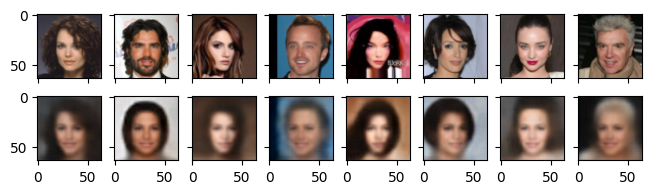

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=8, sharex="all", sharey="all", layout="compressed")

for i in range(8):
    orgs = xs[i].squeeze().detach().transpose(0, -1).cpu()
    estimates = x_hats[i].squeeze().detach().transpose(0, -1).cpu()
    axes[0, i].imshow(orgs)
    axes[1, i].imshow(estimates)

fig.savefig("ppc_celeba_recons.pdf", bbox_inches="tight")
plt.show()

In [12]:
del xs
del x_hats

In [13]:
model.graph.clear()

In [14]:
model.graph(P=model.num_particles, B=8, prior=True)
for _ in range(299):
    model.graph(lr=8e-4, P=model.num_particles, B=8)
trace, _ = model.graph(lr=8e-4, P=model.num_particles, B=8)
x_hats = trace.nodes['X']['value'].mean(dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


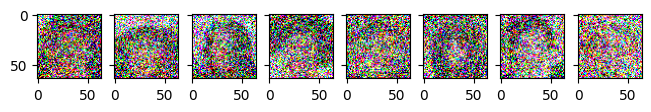

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=8, sharex="all", sharey="all", layout="compressed")

for i in range(8):
    estimates = x_hats[i].squeeze().detach().transpose(0, -1).cpu()
    axes[i].imshow(estimates)

fig.savefig("ppc_celeba_samples.pdf", bbox_inches="tight")
plt.show()

In [16]:
del x_hats
del trace

In [17]:
SEEDS = [123, 456, 789, 101112, 131415]

In [18]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [20]:
with torch.no_grad():
    for (s, SEED) in enumerate(SEEDS):
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        for b, (xs, target, indices) in enumerate(data.val_dataloader()):
            xs = xs.to(model.device)
            model._load_particles(indices, False)
    
            trace, _ = model.graph(P=model.num_particles, xs=xs)
            x_hats = trace.nodes['X']['value'].mean(dim=0)
            LOG_LIKELIHOODS[s] += trace.nodes['X']['fn'].log_prob(xs).sum().cpu()
            MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean().cpu()
    
            del xs
            del x_hats
            del trace
            del target
            del indices
            logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))
    
        LOG_LIKELIHOODS[s] /= len(data.val_dataloader().dataset)
        MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().dataset)

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0
Evaluated likelihood for valid batch 4 under seed 0


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluated likelihood for valid batch 0 under seed 1
Evaluated likelihood for valid batch 1 under seed 1
Evaluated likelihood for valid batch 2 under seed 1
Evaluated likelihood for valid batch 3 under seed 1
Evaluated likelihood for valid batch 4 under seed 1
Evaluated likelihood for valid batch 0 under seed 2
Evaluated likelihood for valid batch 1 under seed 2
Evaluated likelihood for valid batch 2 under seed 2
Evaluated likelihood for valid batch 3 under seed 2
Evaluated likelihood for valid batch 4 under seed 2
Evaluated likelihood for valid batch 0 under seed 3
Evaluated likelihood for valid batch 1 under seed 3
Evaluated likelihood for valid batch 2 under seed 3
Evaluated likelihood for valid batch 3 under seed 3
Evaluated likelihood for valid batch 4 under seed 3
Evaluated likelihood for valid batch 0 under seed 4
Evaluated likelihood for valid batch 1 under seed 4
Evaluated likelihood for valid batch 2 under seed 4
Evaluated likelihood for valid batch 3 under seed 4
Evaluated li

In [21]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-45692.1094), tensor(0.8664))

In [22]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0734), tensor(0.))